# Pipeline planejado 2017-12-13
1. Usar 70.000 imagens adquiridas pelo protótipo AJNA COV Santos - 2017-07 e 2017-08
2. Usar método protótipo AJNA de recorte do contêiner("naive walk")
3. Gerar arquivo com coordenadas (gravar arq. com timestamp no nome para
   não perder alterações manuais se rodar de novo)
4. Gerar métrica/estatística de acerto (histograma das linhas laterais???)
5. Gerar 100 imagens com piores métricas com "bounding boxe" para testar acerto da métrica 4
6. Refinada a métrica 4, gerar lista ordenada de imagens com erros
7. Validade a métrica 4, estabelecer threshold para eliminar da lista imagens com erro
8. Etiquetar MANUALMENTE 20 a 50 imagens que "naive walk" falhou (Estas imagens são as 
   mais importantes para treinar dado que para as outras o próprio "naive walk" já acertou)
9. Treinar algoritmo (YOLO? SSD?)
10. De acordo com acurácia, repetir 8 para aumentar base de treino(ou trocar algoritmo)

Observações:

Foi necessário instalar por fora do AJNA:

LabelImg para criar boxes para detecção de objetos

LabelImg requires lxml, sip e PyQt5

Keras-retinanet para criar algoritmo
Keras-retinanet requires opencv-python, pillow e h5py


# First, check enviroment configuration.
### If AJNA_MOD not installed on Jupyter, run lines bellow on bash(on AJNA_MOD base_dir):
. venv/bin/activate

pip install ipykernel
#### Now run the kernel "self-install" script:
python -m ipykernel install --user --name=venv

In [ ]:
import sys

In [5]:
print(sys.executable)
print(sys.path)
from padma.models.bbox.bbox import find_conteiner

/home/ivan/anaconda3/bin/python
['/home/ivan/pybr/ajna_docs/ajna_commons', '', '/home/ivan/anaconda3/lib/python36.zip', '/home/ivan/anaconda3/lib/python3.6', '/home/ivan/anaconda3/lib/python3.6/lib-dynload', '/home/ivan/.local/lib/python3.6/site-packages', '/home/ivan/anaconda3/lib/python3.6/site-packages', '/home/ivan/pybr/keras-retinanet/keras-resnet', '/home/ivan/pybr/ajna_docs/padma', '/home/ivan/pybr/ajna_docs/bhadrasana', '/home/ivan/anaconda3/lib/python3.6/site-packages/IPython/extensions', '/home/ivan/.ipython']


In [6]:
import imageio
im = imageio.imread('/home/ivan/Área de trabalho/2017/01/01/BSIU2580749/20170101002612000ES_stamp.jpg')
print(im.shape)
im = im[:,:,0]
print(im.shape)
print(im)

print(['123', *(1, 2, 3)])

OSError: No such file: '/home/ivan/Área de trabalho/2017/01/01/BSIU2580749/20170101002612000ES_stamp.jpg'

## Now configure the path of images, count the number of images available, test find_conteiner function

In [10]:
import csv
import datetime
import os
import glob
IMG_PATH = '/home/ivan/Área de trabalho/2017'

lista = []
for filename in glob.iglob(IMG_PATH+'**/*/*/*/*stamp.jpg*', recursive=True):
    lista.append(filename)
    
print(lista[:4])
print(len(lista))
print(find_conteiner(lista[1]))
print(find_conteiner(lista[15]))

[]
0


IndexError: list index out of range

In [11]:
from IPython.display import clear_output

def save_annotations(adict):
    timestamp = datetime.datetime.today().strftime('%Y%m%d%H%M')
    filename = 'annotations_' + timestamp + '.csv'
    print(filename)
    with open(os.path.join('.', filename), 'w', newline='') as out:
        writer = csv.writer(out)
        for key, value in adict.items():
            line = [key, *value]
            writer.writerow(line)

def create_anottations(lista, save=True):
    """Use dumb walk heuristic to create anottations
    Args: 
    
        lista: list of images
        save: if true, save on current directory a csv <annottations_timestamp.csv>
    
    Returns: 
        
        a dict with name of image: (xleft, ytop, xright, ytop) coordinates
    """
    cont = 0
    result = {}
    for img in lista:
        try:
            result[img] = find_conteiner(img)
        except ValueError:
            pass
        cont += 1
        if cont % 100 == 0:
            clear_output()
            print('...', cont, '...')
    if save:
        save_annotations(result)
    return result
    
def draw_anottation():
    """Create red boxes on images for visual annotations checking
    Will have to save RGB images inside of 'L' greyscale"""
    pass


In [12]:
dict = create_anottations(lista)

annotations_201807181014.csv


In [6]:
# 8 Pipeline 
def estimate_anottation_correct(img, coords, line_width=2, threshold=0.8):
    """Make histograms of boundaries to estimate annotation error
    (if boundaries are blank, high chance of dumb walk failure)"""
    total = 0
    cont = 0
    xleft, ytop, xright, ybottom = [int(c) for c in coords]
    leftside = img[ytop:ybottom, xleft:xleft + line_width - 1]
    rightside = img[ytop:ybottom, xright - line_width:xright]
    topside = img[ytop:ytop + line_width - 1, xleft:xright]
    bottomside = img[ybottom - line_width:ybottom, xleft:xright]
    total = leftside.sum() + rightside.sum() #+ topside.sum() + bottomside.sum()
    cont = leftside.size + rightside.size #+ topside.size + bottomside.size
    """for y in range(ytop, ybottom):
        for x in range(xleft, xright):
            total += img[y, xleft:xleft + line_width].sum()  # Left side
            total += img[y, xright - line_width:xright].sum()  # Right side
            total += img[ytop:ytop + line_width, x].sum()  # Top side
            total += img[ybottom - line_width:ybottom, x].sum()  # Bottom side
            cont +=1
    """
    percent_black =  total / cont 
    return int(percent_black)


In [7]:
read_filename = './annotations_201712131226.csv'
import numpy as np
from scipy import stats

lista1 = []
lista2 = []
lista3 = []
with open(read_filename, 'r', newline='') as read, \
        open(read_filename+'.points', 'w', newline='') as write:
    reader = csv.reader(read)
    writer = csv.writer(write)
    for line in reader:
        #print(line)
        img = imageio.imread(line[0])
        lista1.append(estimate_anottation_correct(img, line[1:5], line_width=1))
        points = estimate_anottation_correct(img, line[1:5])
        lista2.append(points)
        lista3.append(estimate_anottation_correct(img, line[1:5], line_width=3))
        line.append(points)
        writer.writerow(line)


In [8]:
X = np.array(lista1)
stats.describe(X)

DescribeResult(nobs=98, minmax=(1, 254), mean=89.948979591836732, variance=2723.9252051335998, skewness=1.0007789709363746, kurtosis=1.435805895115716)

In [9]:
X = np.array(lista2)
stats.describe(X)

DescribeResult(nobs=98, minmax=(13, 250), mean=80.540816326530617, variance=1582.993162213339, skewness=1.650286916097961, kurtosis=5.1576148238619055)

In [10]:
X = np.array(lista3)
stats.describe(X)

DescribeResult(nobs=98, minmax=(16, 250), mean=73.714285714285708, variance=1458.1443298969073, skewness=2.116414384638423, kurtosis=7.024927684668105)

In [15]:
import pandas as pd
read_filename = './annotations_201712131226.csv'

df = pd.read_csv(read_filename+'.points', names=('filename', 'x1', 'y1', 'x2', 'y2', 'points'))

In [16]:
df.head()

,filename,x1,y1,x2,y2,points
0,/home/ivan/Área de trabalho/2017/07/28/UESU432...,7,33,381,252,61
1,/home/ivan/Área de trabalho/2017/07/28/UACU596...,10,21,439,232,59
2,/home/ivan/Área de trabalho/2017/07/28/UETU547...,0,20,472,201,87
3,/home/ivan/Área de trabalho/2017/07/28/UESU514...,18,25,492,201,110
4,/home/ivan/Área de trabalho/2017/07/29/AMFU301...,261,38,481,158,74


In [13]:
df = df.sort_values('points')
df.head()

,filename,x1,y1,x2,y2,points
21,/home/ivan/Área de trabalho/2017/07/28/YMLU881...,35,0,599,195,13
6,/home/ivan/Área de trabalho/2017/07/29/APHU708...,11,0,599,222,13
76,/home/ivan/Área de trabalho/2017/07/29/APZU311...,141,19,599,175,14
91,/home/ivan/Área de trabalho/2017/07/29/APHU717...,36,0,599,153,19
67,/home/ivan/Área de trabalho/2017/07/28/UTCU473...,143,21,599,159,27


In [13]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn
%matplotlib inline

In [15]:
from collections import OrderedDict
num_imgs = len(df)

bboxes = np.zeros((num_imgs, 4))
imgs = OrderedDict()
for index, row in df.iterrows():
    im = imageio.imread(row['filename'])[:,:,0]
    #bboxe
    imgs[index] = (im, os.path.basename(os.path.split(row['filename'])[0]))
    bboxes[index] = [row['x1'], row['y1'], row['x2'], row['y2']]


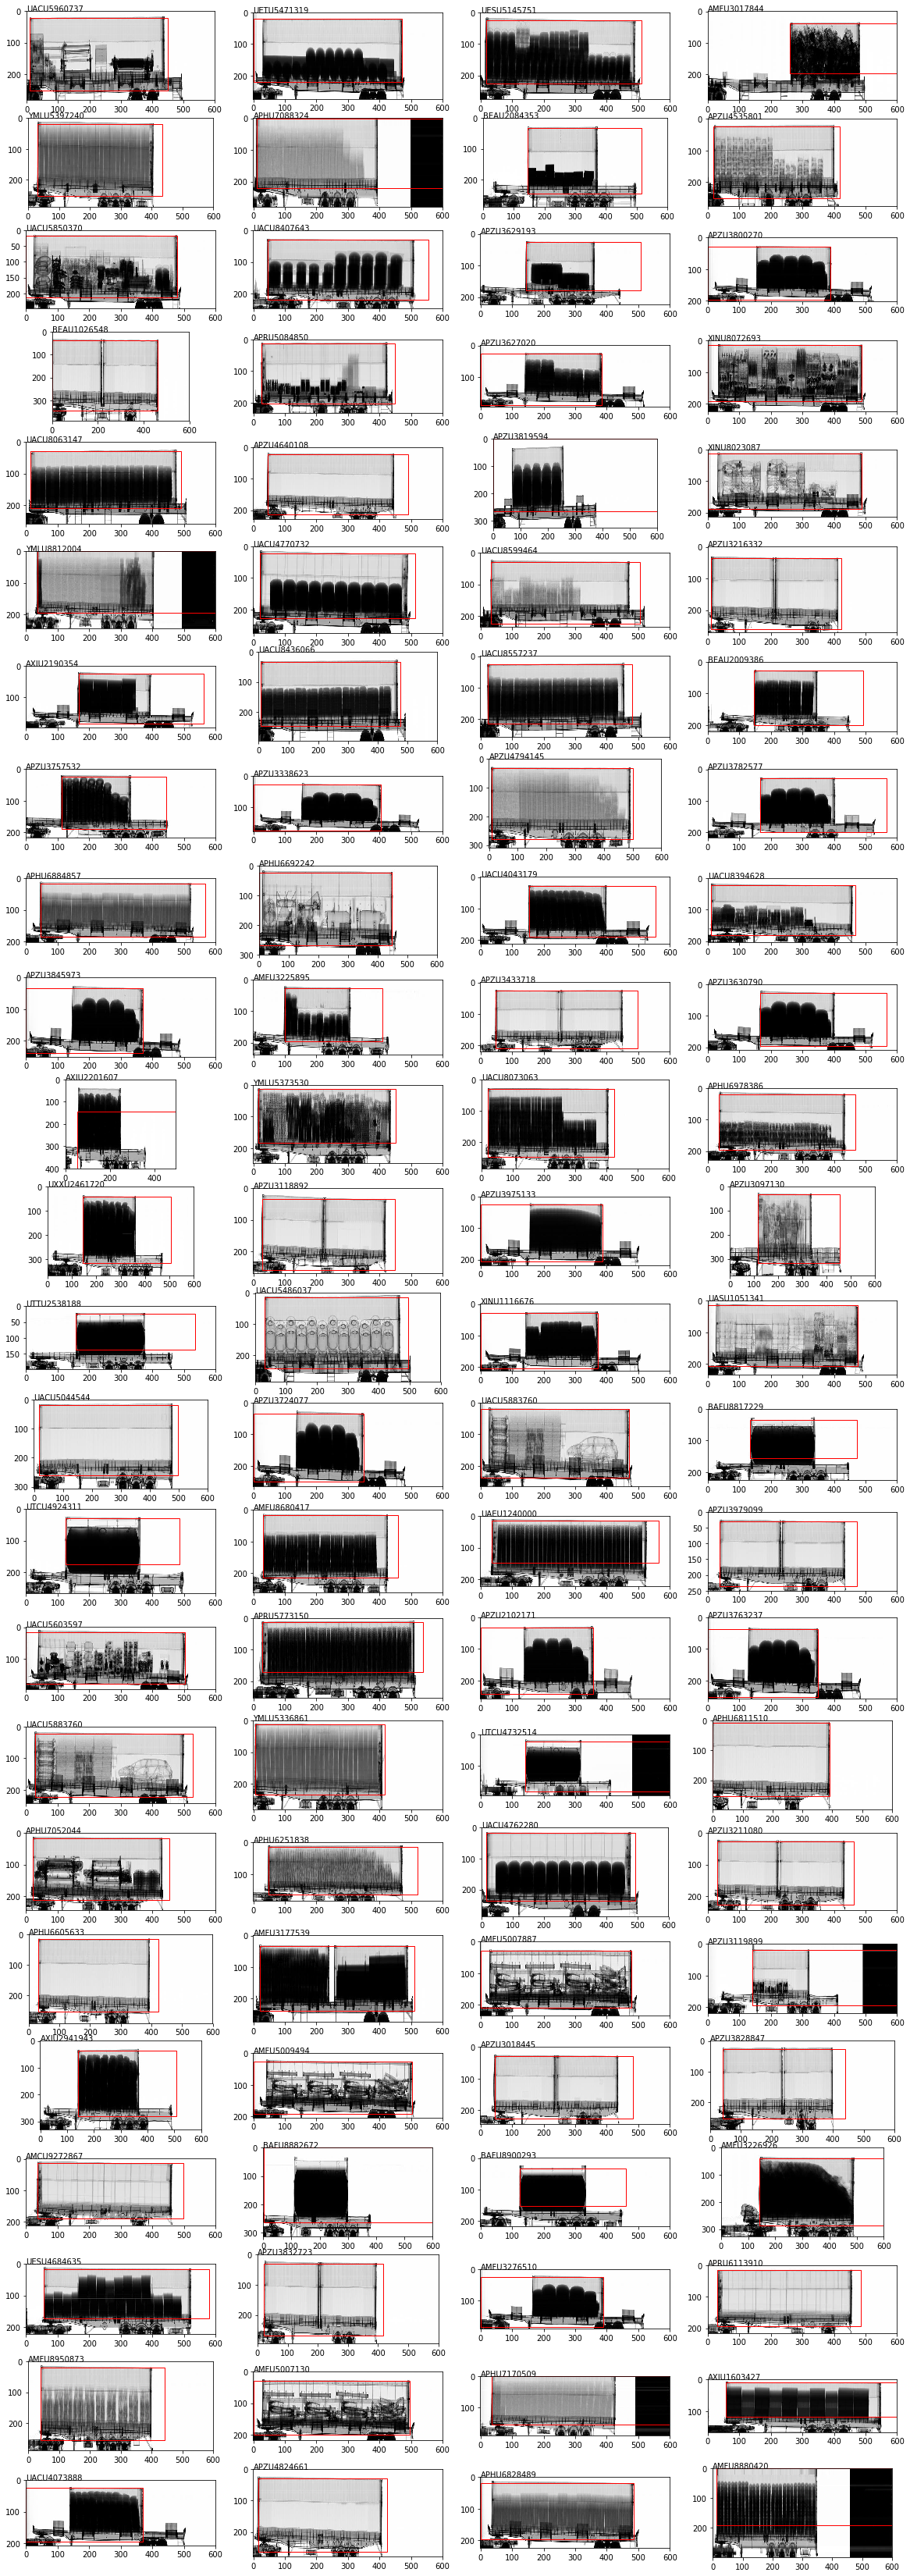

In [17]:
plt.figure(figsize=(20, 60))
for i in range(1, 97):
    plt.subplot(24, 4, i)
    plt.imshow(imgs[i][0], cmap='gray')
    bbox = bboxes[i]
    plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))
    plt.annotate(imgs[i][1], (0, 0))

In [1]:
plt.figure(figsize=(20, 60))
for i in range(1, 97):
    plt.subplot(24, 4, i)
    im = np.array((imgs[i][0], imgs[i][0], imgs[i][0]))
    im = im.swapaxes(1, 2)
    im = im.swapaxes(0, 2)
    bbox = bboxes[i] 
    #print(bbox)
    #print(im.shape)
    #print(im)
    #print(im[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[0])+4])
    #im[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[0])+5, 0] = 0
    #im[int(bbox[1]):int(bbox[1])+5, int(bbox[0]):int(bbox[2]), 0] = 0
    #im[int(bbox[1]):int(bbox[3]), int(bbox[2])-5:int(bbox[2]), 0] = 0
    #im[int(bbox[3])-5:int(bbox[3]), int(bbox[0]):int(bbox[2]), 0] = 0
    #print(im[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[0])+4])
    #im[0:200, 0:200] = 0
    plt.imshow(im, cmap='gray')
    #plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))
    plt.annotate(imgs[i][1], (0, 0))

NameError: name 'plt' is not defined

In [40]:
from image_aq.utils.pascal_voc_io import PascalVocWriter

def gera_voc(file):
    foldername, filename = os.path.split(file)
    img = imageio.imread(file)
    imgSize = img.shape
    print(foldername, filename, imgSize)
    voc_writer = PascalVocWriter(foldername, filename, imgSize)
    coords = find_conteiner(file)
    voc_writer.addBndBox(*coords, 'cc', '')
    voc_writer.save(file[:-4]+'.xml')

file = lista[0]
print(file)
gera_voc(file)
glob.glob(foldername+'/*')

/home/ivan/Área de trabalho/2017/01/01/BSIU2580749/20170101002612000ES_stamp.jpg
/home/ivan/Área de trabalho/2017/01/01/BSIU2580749 20170101002612000ES_stamp.jpg (243, 600, 3)


['/home/ivan/Área de trabalho/2017/01/01/BSIU2580749/20170101002612000E.xml',
 '/home/ivan/Área de trabalho/2017/01/01/BSIU2580749/20170101002612000ES_stamp.jpg',
 '/home/ivan/Área de trabalho/2017/01/01/BSIU2580749/20170101002612000ES_stamp.xml']

In [ ]:
# Em 2017-12-14 10h comentei o gerador de VOC porque estou refinando os boxes gerados através do aplicativo LabelImg
for file in lista:
#    gera_voc(file)


In [5]:
# Copiar anotações já revisadas com LabelImg - anotar manualmente último contêiner trabalhado no LabelImg 
# para não copiar labels não revisados
from shutil import copyfile

IMG_PATH = '../image_aq/files/conteiner_to_check/'
cont = 0
for file in lista[100:1000]:
    cont +=1
    # print(file)
    basename = os.path.basename(file)
    # print(basename)
    copyfile(file, os.path.join(IMG_PATH, basename))
    copyfile(file[:-4]+'.xml', os.path.join(IMG_PATH, basename[:-4]+'.xml'))
    #if file.find('CMAU122') != -1:
    #    break
print(cont)

900


In [21]:
# Criar formato csv necessário para o keras-retinanet - https://github.com/fizyr/keras-retinanet

from image_aq.utils.pascal_voc_io import PascalVocReader

with open('keras-retinanet.csv', 'w', newline='') as kerascsv:
    writer = csv.writer(kerascsv)
    for xml in glob.glob(IMG_PATH+'*stamp.xml'):
        # print(xml)
        voc_reader = PascalVocReader(xml)
        for shape in voc_reader.shapes:
            #print(shape)
            classe = shape[0]
            coords = shape[1]
            # x1, y1, x2, y2 - Ver pascal_voc_io.py linha 152 E
            # https://github.com/fizyr/keras-retinanet/README #AnnotationsFormat
            coords = (coords[0][0], coords[0][1], coords[2][0], coords[2][1])
            # print(coords)
            line = (xml[:-3]+'jpg', *coords, 'cc')
            # print(line)
            writer.writerow(line)
        
!echo 'cc,0' > classes.txt
